## ⚙️ Import Libraries

In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 0


## ⏳ Load the Data

In [45]:
DATA_DIR = Path().absolute() / "data"
DATA_DIR

PosixPath('/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-2/data')

In [46]:
data = np.load(DATA_DIR / "mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [47]:
X_train = X_test

## Analyze data


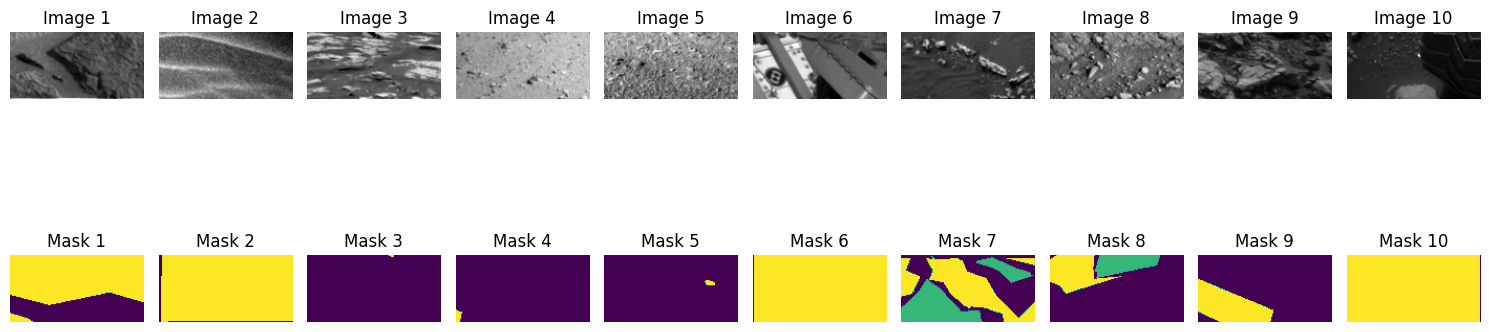

In [48]:
# Visualize the data
# Reshape to 2D for visualization
X_train_images = np.array([x.reshape(64, 128) for x in X_train])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train])

# Plot the first 5 images and their corresponding masks
fig, axes = plt.subplots(2, 10, figsize=(15, 6))
for i in range(10):
    # Input images
    axes[0, i].imshow(X_train_images[i], cmap="gray")
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis("off")

    # Masks
    axes[1, i].imshow(y_train_masks[i], cmap="viridis")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

## Class Imbalance

In [49]:
# Define class labels as a dictionary
class_labels = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}


Class Distribution in Masks (Filtered Dataset):
Class 0.0 (Background): 5466886 pixels
Class 1.0 (Soil): 7131118 pixels
Class 2.0 (Bedrock): 4863930 pixels
Class 3.0 (Sand): 3933183 pixels
Class 4.0 (Big Rock): 26963 pixels


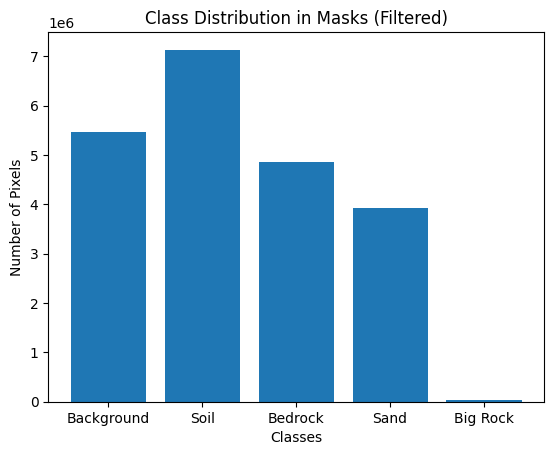

In [50]:
# Count the number of pixels per class
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print class distribution
print("Class Distribution in Masks (Filtered Dataset):")
for class_id, count in class_distribution.items():
    print(f"Class {class_id} ({class_labels[class_id]}): {count} pixels")

# Visualize class distribution
plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[class_labels[c] for c in class_distribution.keys()])
plt.title("Class Distribution in Masks (Filtered)")
plt.xlabel("Classes")
plt.ylabel("Number of Pixels")
plt.show()


In [51]:
total_pixels = np.prod(y_train_masks.shape)
class_percentages = {class_labels[c]: (count / total_pixels) * 100 for c, count in class_distribution.items()}
print("Class Percentages:")
for label, percent in class_percentages.items():
    print(f"{label}: {percent:.2f}%")


Class Percentages:
Background: 25.52%
Soil: 33.29%
Bedrock: 22.71%
Sand: 18.36%
Big Rock: 0.13%


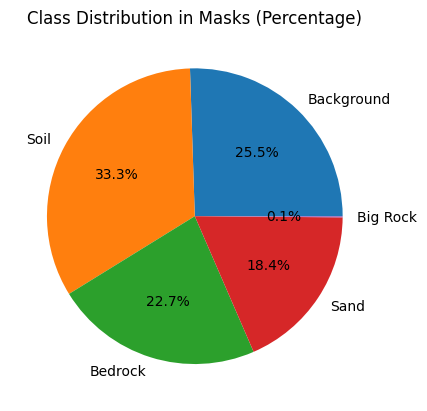

In [52]:
plt.pie(class_distribution.values(), labels=[class_labels[c] for c in class_distribution.keys()], autopct='%1.1f%%')
plt.title("Class Distribution in Masks (Percentage)")
plt.show()


In [53]:
# Identify empty masks
empty_mask_indices = [i for i, mask in enumerate(y_train_masks) if np.all(mask == 0)]
print(f"Number of empty masks: {len(empty_mask_indices)}")

# Check for masks with only one class
single_class_masks = [i for i, mask in enumerate(y_train_masks) if len(np.unique(mask)) == 1]
print(f"Number of masks with a single class: {len(single_class_masks)}")


Number of empty masks: 7
Number of masks with a single class: 425


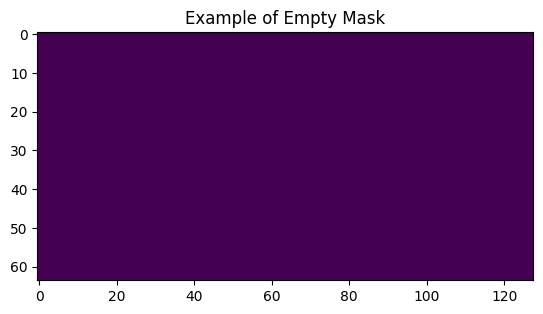

In [54]:

if empty_mask_indices:
    plt.imshow(y_train_masks[empty_mask_indices[0]], cmap="viridis")
    plt.title("Example of Empty Mask")
    plt.show()


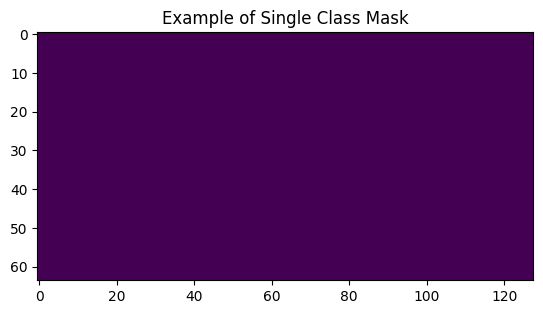

In [55]:

if single_class_masks:
    plt.imshow(y_train_masks[single_class_masks[20]], cmap="viridis")
    plt.title("Example of Single Class Mask")
    plt.show()


## Outliers

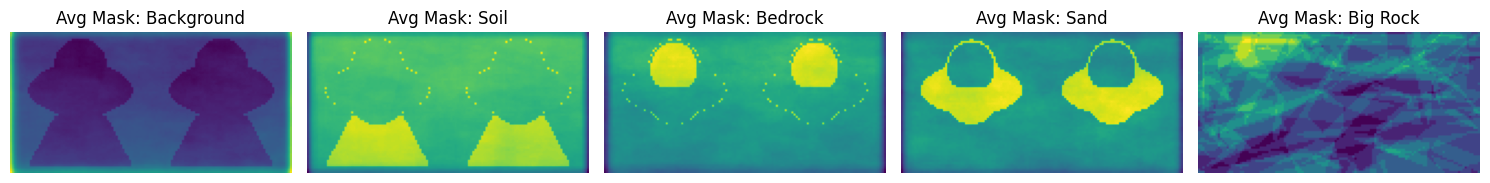

In [56]:
avg_masks = {}
for class_id in class_labels.keys():
    avg_masks[class_id] = np.mean((y_train_masks == class_id), axis=0)

# Plot average masks
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))
for class_id, ax in zip(class_labels.keys(), axes):
    ax.imshow(avg_masks[class_id], cmap="viridis")
    ax.set_title(f"Avg Mask: {class_labels[class_id]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


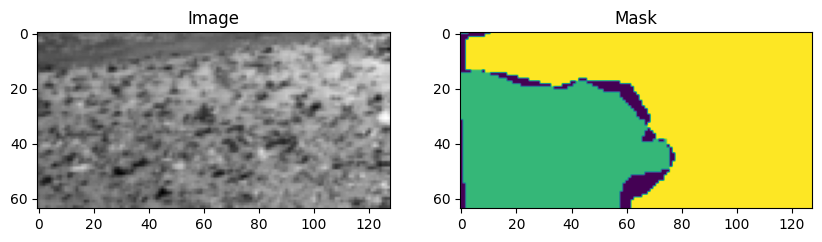

IndexError: index 6174 is out of bounds for axis 0 with size 2615

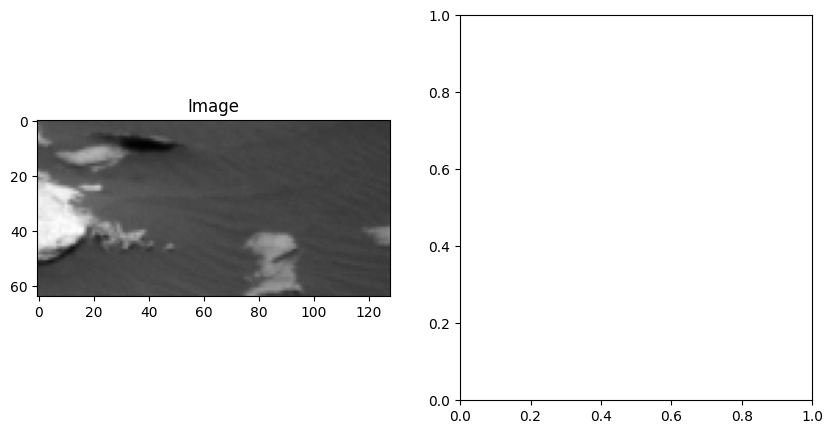

In [57]:
import random

# Randomly sample a few image-mask pairs
for _ in range(10):
    idx = random.randint(0, len(X_train_images) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_train_images[idx], cmap="gray")
    ax[0].set_title("Image")
    ax[1].imshow(y_train_masks[idx], cmap="viridis")
    ax[1].set_title("Mask")
    plt.show()


In [58]:
import numpy as np

# Calculate mean and standard deviation of pixel intensities for each image
image_features = np.array([[np.mean(img), np.std(img)] for img in X_train])

print(f"Feature shape: {image_features.shape}")


Feature shape: (10022, 2)


/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


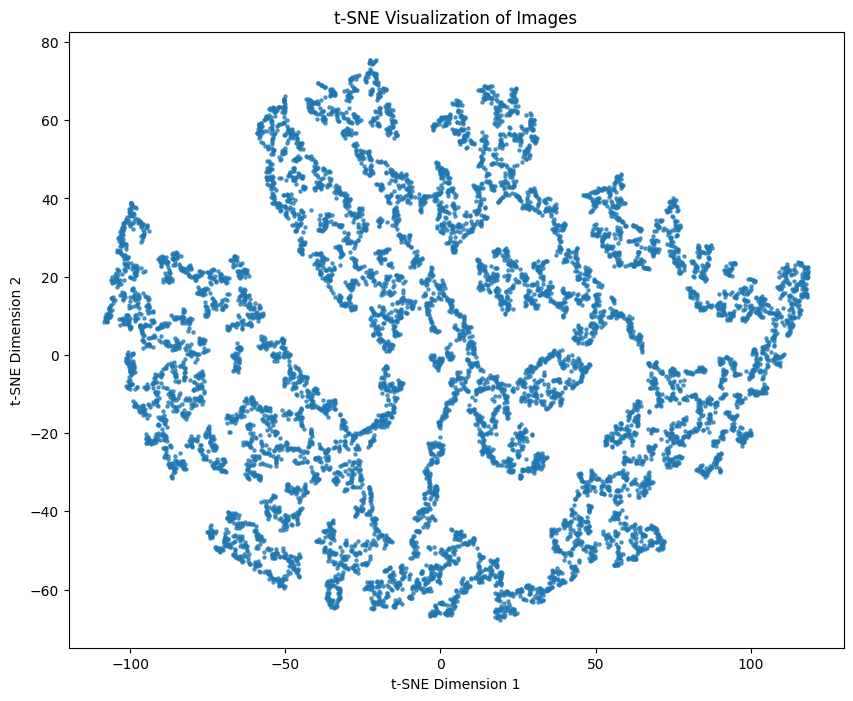

In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
image_tsne = tsne.fit_transform(image_features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(image_tsne[:, 0], image_tsne[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Images")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


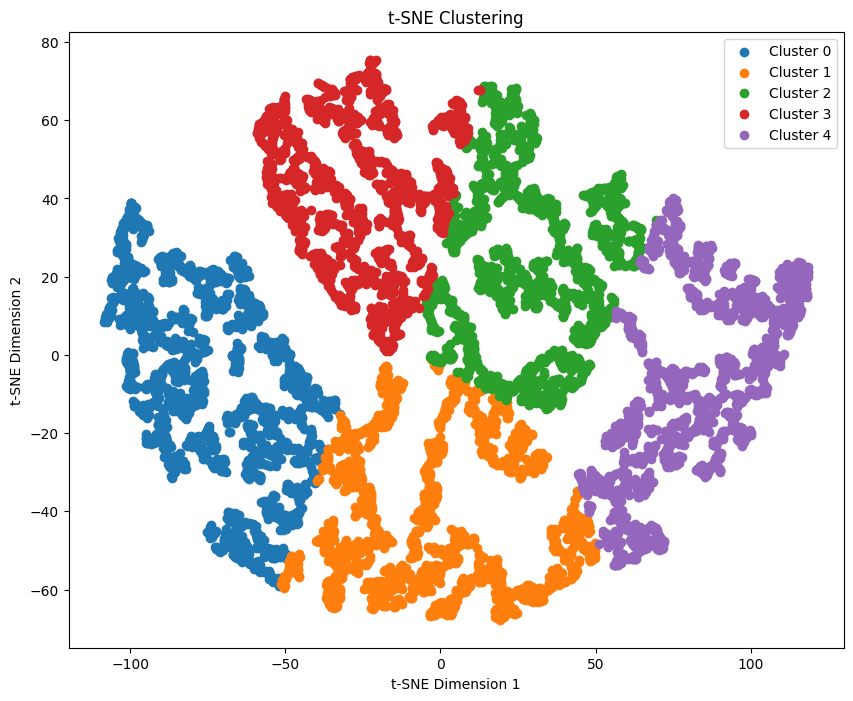

In [60]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
labels = kmeans.fit_predict(image_tsne)

# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster in np.unique(labels):
    plt.scatter(image_tsne[labels == cluster, 0], image_tsne[labels == cluster, 1], label=f"Cluster {cluster}")
plt.legend()
plt.title("t-SNE Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


Number of images in Cluster 4: 110


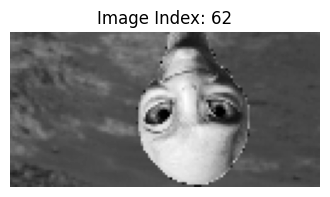

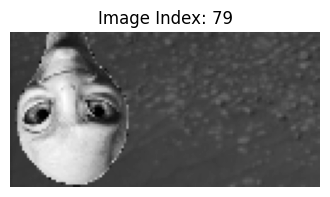

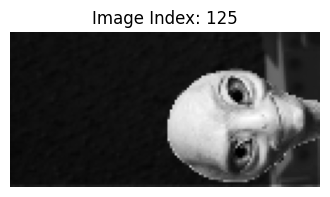

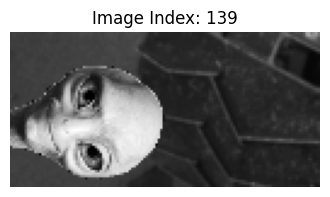

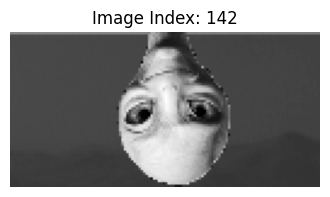

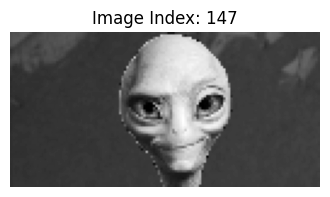

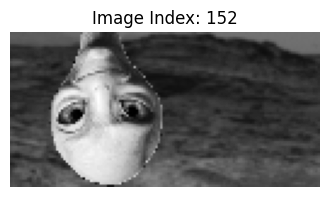

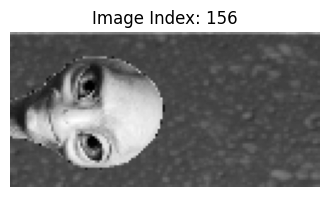

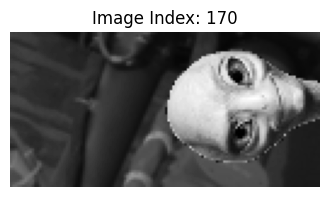

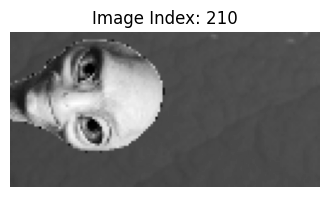

In [ ]:
import matplotlib.pyplot as plt

# Assuming `labels` contains the cluster assignments from k-means or another clustering method
# Find indices of images in Cluster 4 (purple cluster)
cluster_4_indices = [i for i, label in enumerate(labels) if label == 4]

print(f"Number of images in Cluster 4: {len(cluster_4_indices)}")

# Visualize images in Cluster 4
for idx in cluster_4_indices[:10]:  # Show the first 10 images in the cluster
    plt.figure(figsize=(4, 4))
    plt.imshow(X_train[idx].squeeze(), cmap="gray")
    plt.title(f"Image Index: {idx}")
    plt.axis("off")
    plt.show()


In [ ]:
import os
from PIL import Image

# Create a directory to save images
os.makedirs("cluster_4_images", exist_ok=True)

# Save images in Cluster 4
for idx in cluster_4_indices:
    image = X_train[idx].squeeze()
    Image.fromarray((image * 255).astype(np.uint8)).save(f"cluster_4_images/image_{idx}.png")


### Outliers removed

In [ ]:
# Remove Cluster 4 indices from X_train_filtered and y_train_filtered
import numpy as np

# Find indices of images in Cluster 4 (purple cluster)
cluster_4_indices = [i for i, label in enumerate(labels) if label == 4]

print(f"Number of images in Cluster 4: {len(cluster_4_indices)}")

# Create filtered datasets by excluding Cluster 4 indices
X_train_filtered = np.delete(X_train, cluster_4_indices, axis=0)
y_train_filtered = np.delete(y_train, cluster_4_indices, axis=0)

print(f"Updated dataset size: {X_train_filtered.shape[0]} images, {y_train_filtered.shape[0]} masks")


Number of images in Cluster 4: 110
Updated dataset size: 2505 images, 2505 masks


In [ ]:
X_train_images = np.array([x.reshape(64, 128) for x in X_train_filtered])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train_filtered])

In [43]:
np.savez(
    DATA_DIR / "clean" / "train.npz",
    x=X_train_images,
    y=y_train_masks,
)
np.savez(
    DATA_DIR / "clean" / "test.npz",
    x=X_test,
)

## Analysis without the outliers

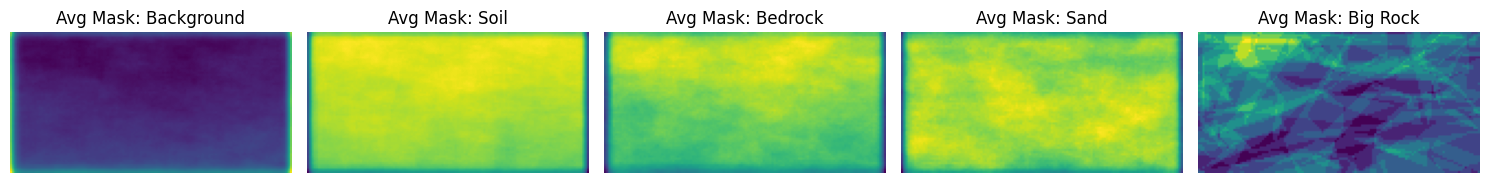

In [25]:
avg_masks = {}
for class_id in class_labels.keys():
    avg_masks[class_id] = np.mean((y_train_masks == class_id), axis=0)

# Plot average masks
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))
for class_id, ax in zip(class_labels.keys(), axes):
    ax.imshow(avg_masks[class_id], cmap="viridis")
    ax.set_title(f"Avg Mask: {class_labels[class_id]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


CLASS IMBALANCE

Class Distribution in Masks (Filtered Dataset):
Class 0.0 (Background): 4988826 pixels
Class 1.0 (Soil): 6957538 pixels
Class 2.0 (Bedrock): 4776810 pixels
Class 3.0 (Sand): 3770823 pixels
Class 4.0 (Big Rock): 26963 pixels


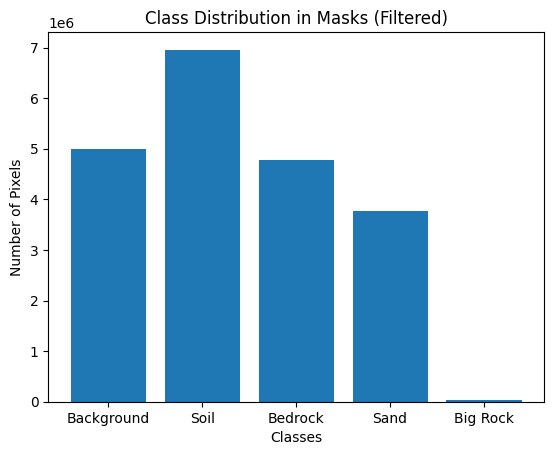

In [26]:
# Count the number of pixels per class
unique, counts = np.unique(y_train_filtered, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print class distribution
print("Class Distribution in Masks (Filtered Dataset):")
for class_id, count in class_distribution.items():
    print(f"Class {class_id} ({class_labels[class_id]}): {count} pixels")

# Visualize class distribution
plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[class_labels[c] for c in class_distribution.keys()])
plt.title("Class Distribution in Masks (Filtered)")
plt.xlabel("Classes")
plt.ylabel("Number of Pixels")
plt.show()


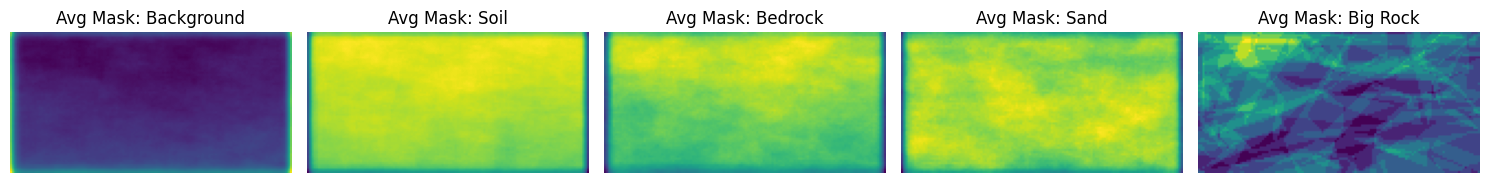

In [27]:
# Compute average mask for each class
avg_masks = {}
for class_id in class_labels.keys():
    avg_masks[class_id] = np.mean((y_train_filtered == class_id), axis=0)

# Visualize average masks
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))
for class_id, ax in zip(class_labels.keys(), axes):
    ax.imshow(avg_masks[class_id], cmap="viridis")
    ax.set_title(f"Avg Mask: {class_labels[class_id]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


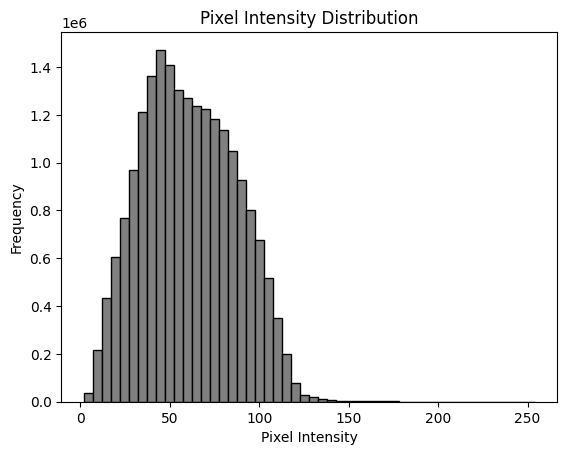

In [61]:
# Flatten all images to a 1D array
pixel_values = X_train_filtered.flatten()

# Plot histogram of pixel intensities
plt.hist(pixel_values, bins=50, color="gray", edgecolor="black")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


In [62]:
# Identify indices of images containing Big Rock (class 4)
big_rock_indices = [i for i, mask in enumerate(y_train_filtered) if 4 in mask]

# Extract images and masks containing Big Rock
X_big_rock = X_train_filtered[big_rock_indices]
y_big_rock = y_train_filtered[big_rock_indices]

print(f"Number of Big Rock images: {len(X_big_rock)}")


Number of Big Rock images: 63


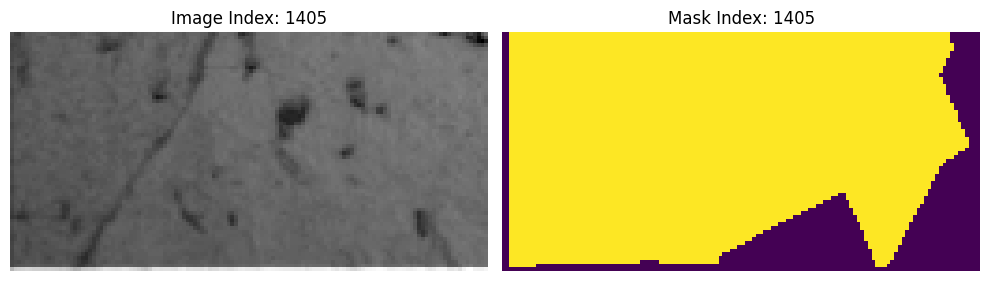

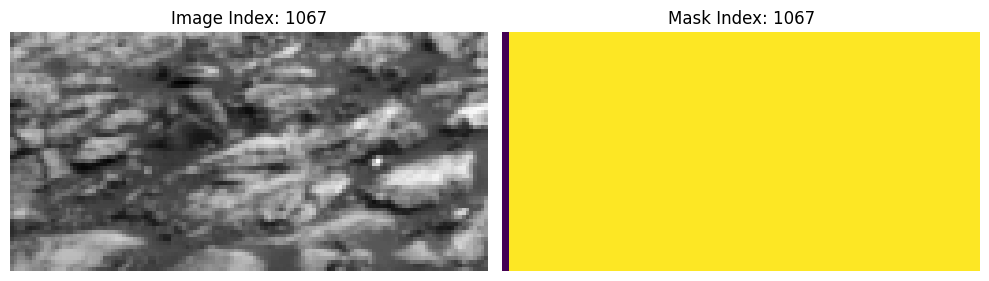

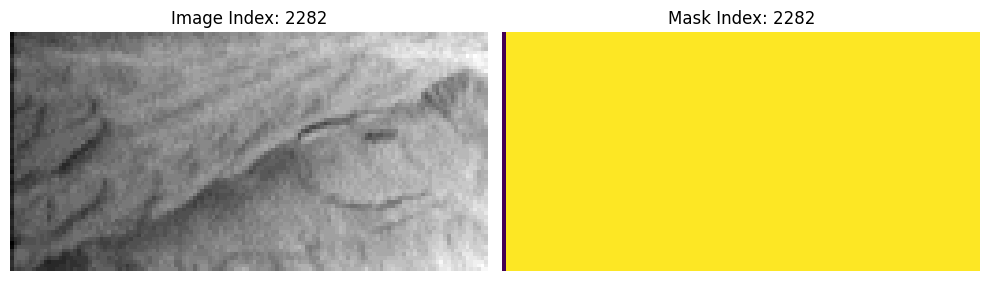

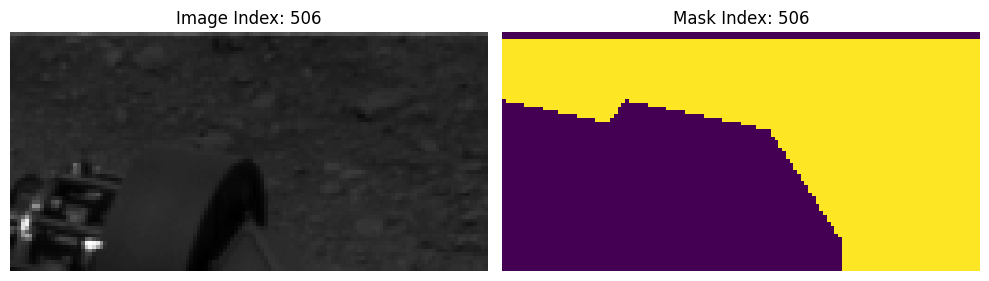

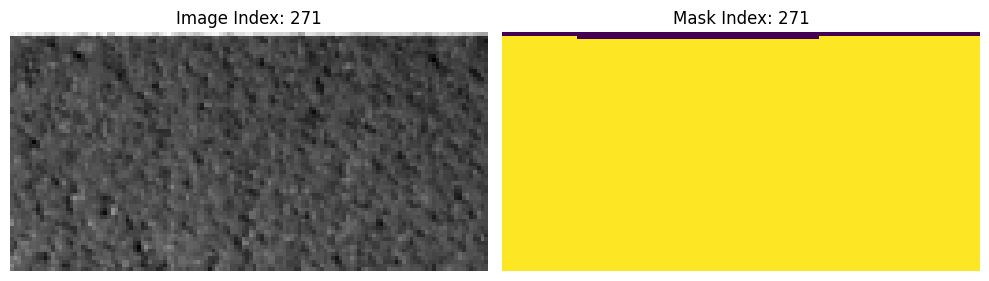

In [63]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train_filtered) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train_filtered[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train_filtered[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


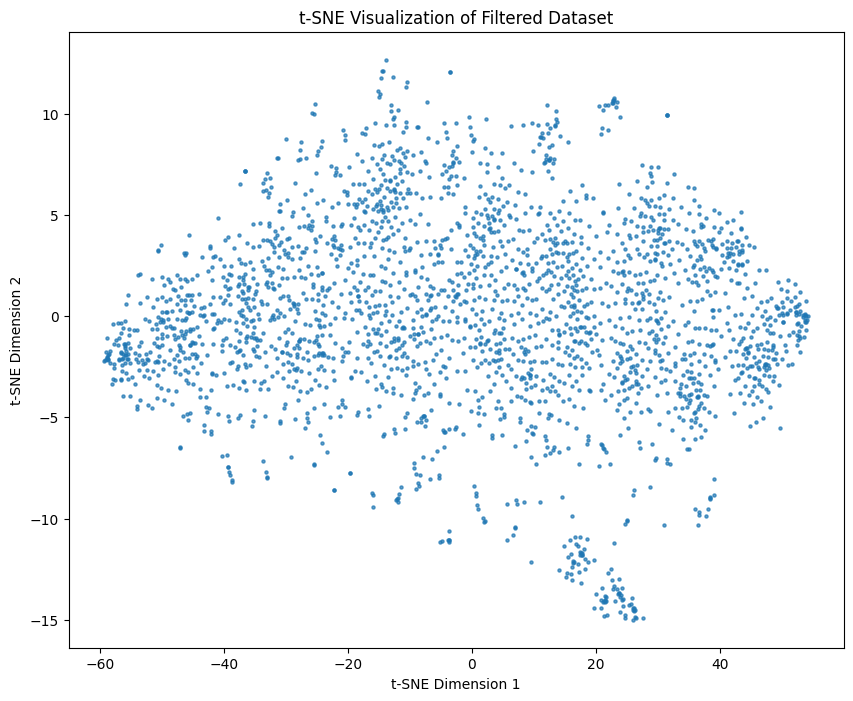

In [31]:
from sklearn.manifold import TSNE

# Flatten images for t-SNE
X_flattened = X_train_filtered.reshape(X_train_filtered.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_flattened)

# Plot t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Filtered Dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


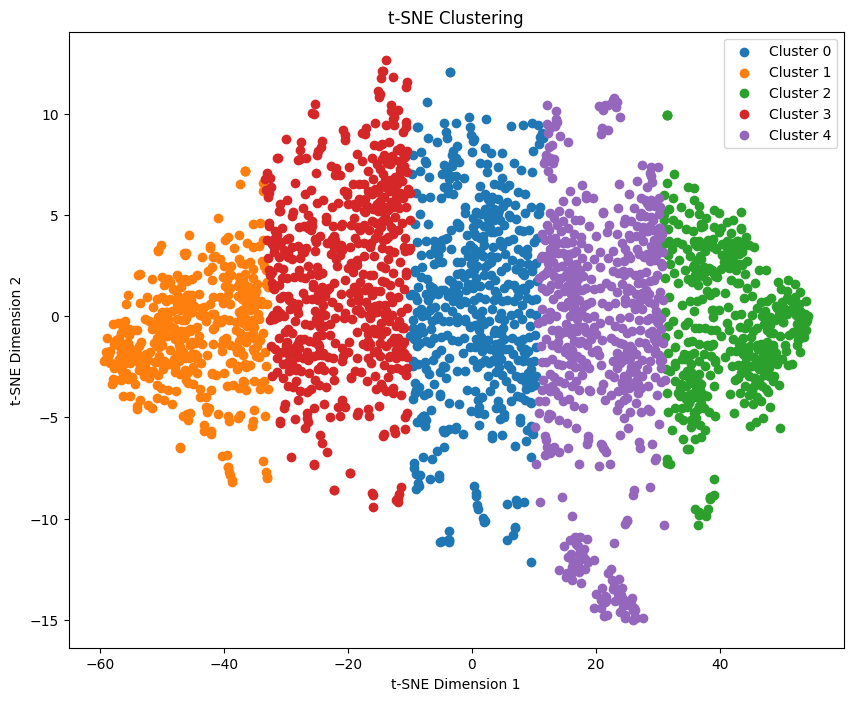

In [32]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
labels = kmeans.fit_predict(X_tsne)

# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster in np.unique(labels):
    plt.scatter(X_tsne[labels == cluster, 0], X_tsne[labels == cluster, 1], label=f"Cluster {cluster}")
plt.legend()
plt.title("t-SNE Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
